In [1]:
from lathes_model import LathesModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

### Initialize Model

In [2]:
kwargs = {'N_PCs':3,
          'clf' : MLPClassifier(alpha=1,max_iter=500),
          'n_jobs':4,
          'granularity':4,
          'percent': 50}

In [3]:
model = LathesModel(**kwargs)

In [4]:
print(model.__doc__)

Lathes Cutting Tool Model Class
    
    Parameters
    ----------
    N_PCs: int, default=3
        Number of components to keep in PCA.
    clf: classifier, default=MLPClassifier
        sklearn binary classifier
    n_jobs: int, default=4
        The number of processes to use for parallelization in tsfresh
    granularity: float, default=3
        SODA granularity, sensibility factor for data partitioning module
    percent: float, default=50
        purity percent for grouping algorithm, must be within (50, 100) interval
        percent=50 means hard voting

    Attributes
    ----------
    N_PCs_: int
        Number of components to keep in PCA.
    n_jobs_: int
        The number of processes to use for parallelization in tsfresh
    granularity_: float
        SODA granularity, sensibility factor for data partitioning module
    percent_: float
        purity percent for grouping algorithm
    eigen_matrix_: np.array
        pca transformation eigen matrix
    nan_columns_: li

### Load dataset

In [5]:
input_id = 1

PATH = '../Input/Input_%i.csv' %(input_id)

In [6]:
full_data = np.genfromtxt(PATH,delimiter=',')

In [7]:
n_measures = int(full_data[:,1].max())
n_timeseries = int(full_data[:,0].max())

inadequate_condition = int(full_data[:,-1].sum()/n_measures)
adequate_condition = n_timeseries - inadequate_condition


print(30*'-')
print('Shape:', full_data.shape)
print(30*'-')
print('Number of Time Series:', n_timeseries)
print('    Adequate Condition:', adequate_condition)
print('    Inadequate Condition:', inadequate_condition)
print(30*'-')
print('Measurments per Time Serie:', n_measures)
print(30*'-')

------------------------------
Shape: (444000, 9)
------------------------------
Number of Time Series: 592
    Adequate Condition: 352
    Inadequate Condition: 240
------------------------------
Measurments per Time Serie: 750
------------------------------


### train_test_split

In [8]:
index = full_data[::n_measures,0].astype(int) - 1
target = full_data[::n_measures,-1]

L, W = full_data.shape

train_idx, test_idx, train_target, test_target = train_test_split(index, target, test_size=.3, 
                                                                  stratify=target, random_state=12)
train_idx.sort()
test_idx.sort()

L_train = train_idx.shape[0]
train_index = np.zeros(L_train*n_measures, dtype=np.int32)
for ii in range(L_train):
    train_index[ii*n_measures:(ii+1)*n_measures] = list(range(train_idx[ii]*n_measures,
                                                                (train_idx[ii]+1)*n_measures)) 
L_test = test_idx.shape[0]
test_index = np.zeros(L_test*n_measures, dtype=np.int32)
for ii in range(L_test):
    test_index[ii*n_measures:(ii+1)*n_measures] = list(range(test_idx[ii]*n_measures,
                                                                (test_idx[ii]+1)*n_measures)) 
    
train_data = full_data[train_index,:]
test_data = full_data[test_index,:]

In [9]:
X_train = train_data[:,:-1]
y_train = train_data[:,-1]

X_test = test_data[:,:-1]
y_test = test_data[:,-1]

### fit

In [10]:
%%time
model.fit(X_train,y_train)

Feature Extraction: 100%|██████████| 20/20 [09:20<00:00, 28.05s/it]


CPU times: user 7.2 s, sys: 4.79 s, total: 12 s
Wall time: 9min 25s


### predict

In [11]:
%%time
y_pred = model.predict(X_test)

Feature Extraction: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


CPU times: user 2.12 s, sys: 483 ms, total: 2.61 s
Wall time: 3min 12s


### Analytics

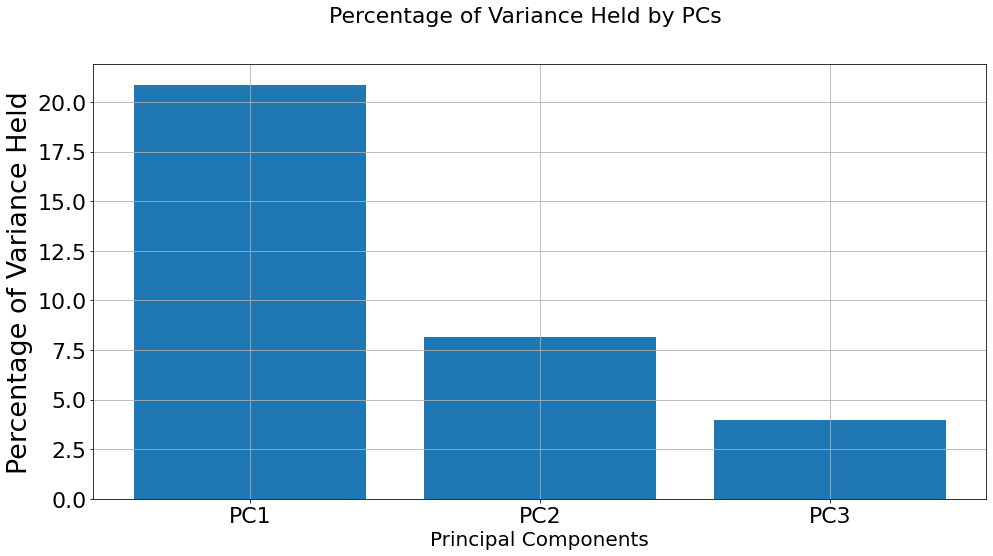

In [12]:
model.plot_variation_held()

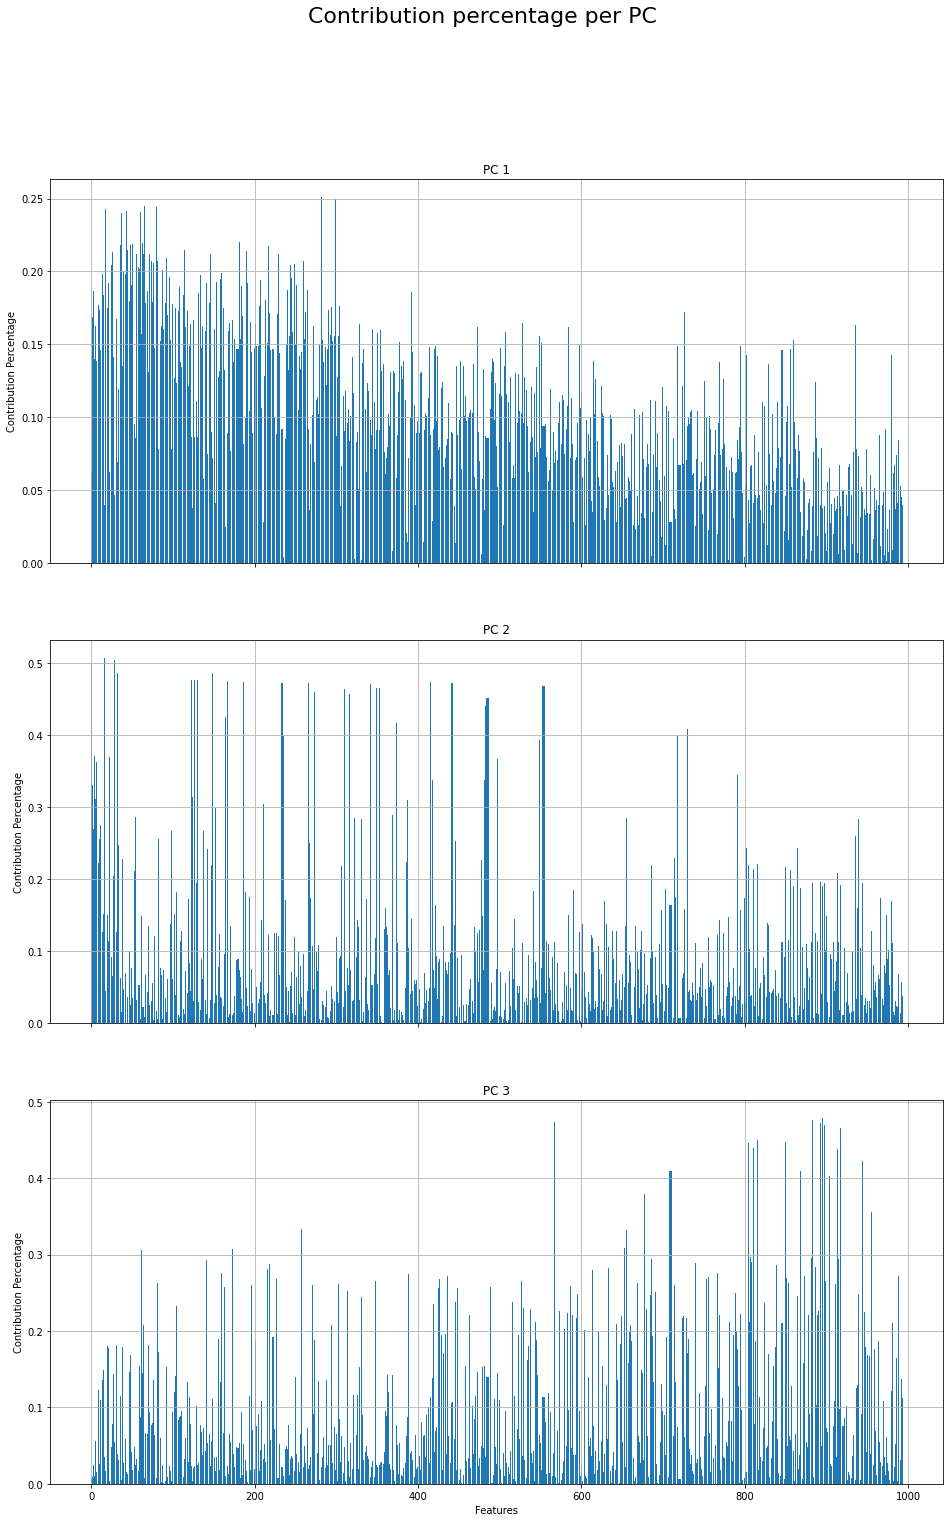

In [13]:
model.plot_contribution_per_PC()

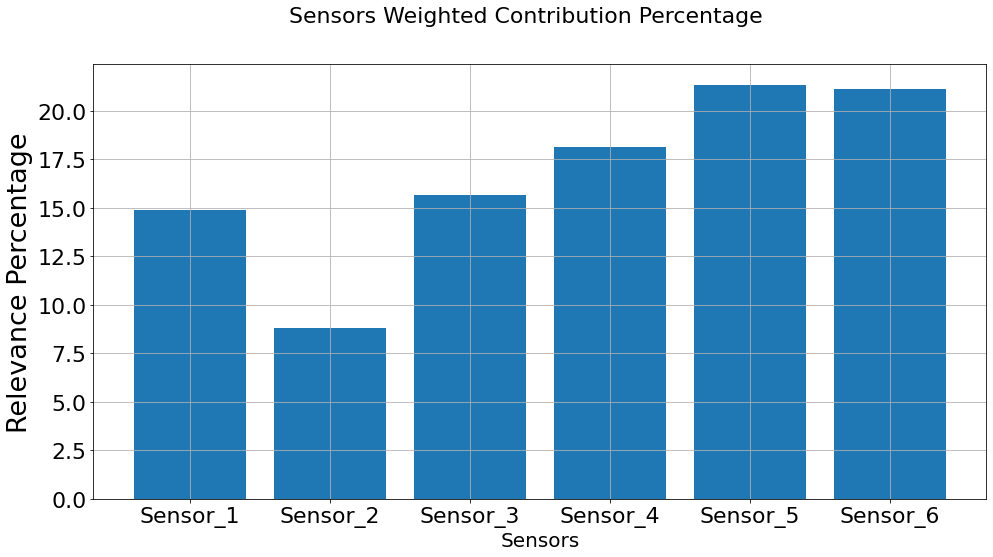

In [14]:
model.plot_sensor_contribution()

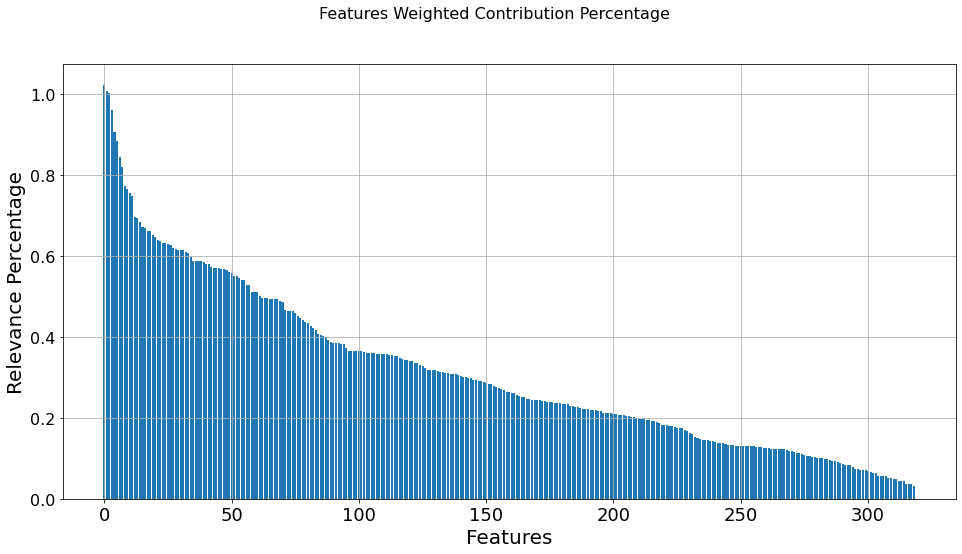

In [15]:
model.plot_features_contribution()

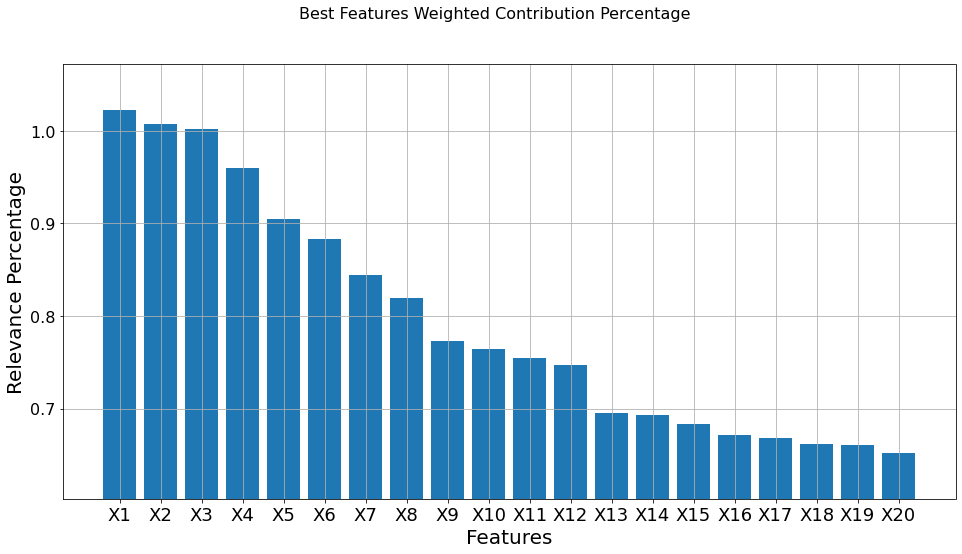

In [16]:
model.plot_best_features_contribution()

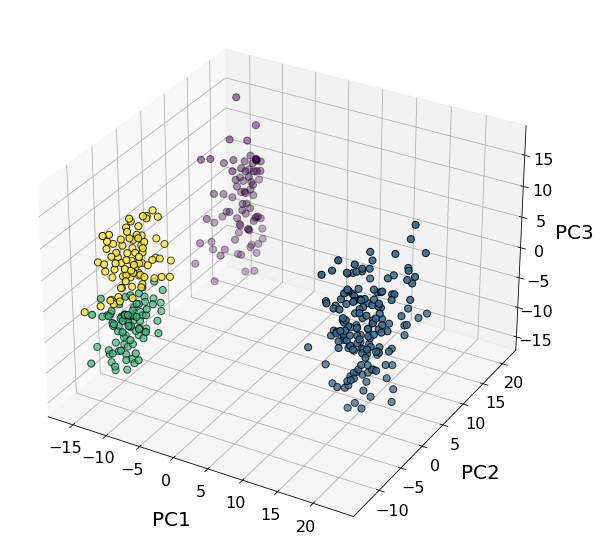

In [17]:
model.plot_soda()

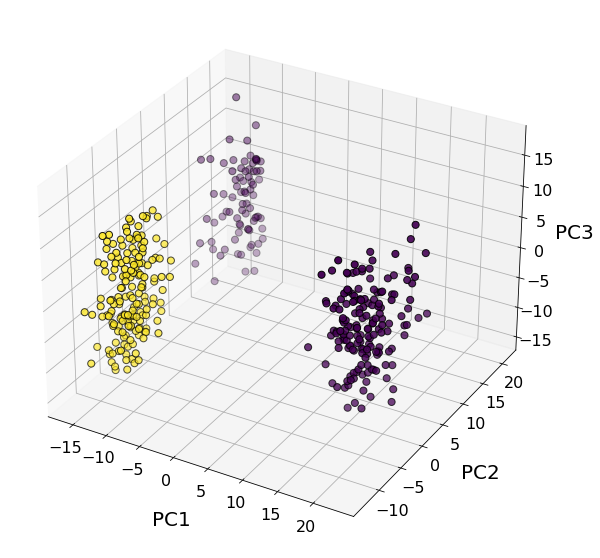

In [18]:
model.plot_GA()

### Metrics

In [19]:
y_test = y_test[::n_measures]

In [20]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [21]:
Accuracy = accuracy_score(y_test,y_pred)*100
Precision = precision_score(y_test, y_pred, zero_division=0)*100
Recall = recall_score(y_test, y_pred, zero_division=0)*100
F1 = f1_score(y_test, y_pred, zero_division=0)*100


print("Accuracy:  {:5.2f}%".format(Accuracy))
print("Precision: {:5.2f}%".format(Precision))
print("Recall:    {:5.2f}%".format(Recall))
print("F1:        {:5.2f}%".format(F1))

Accuracy:  100.00%
Precision: 100.00%
Recall:    100.00%
F1:        100.00%


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

In [23]:
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

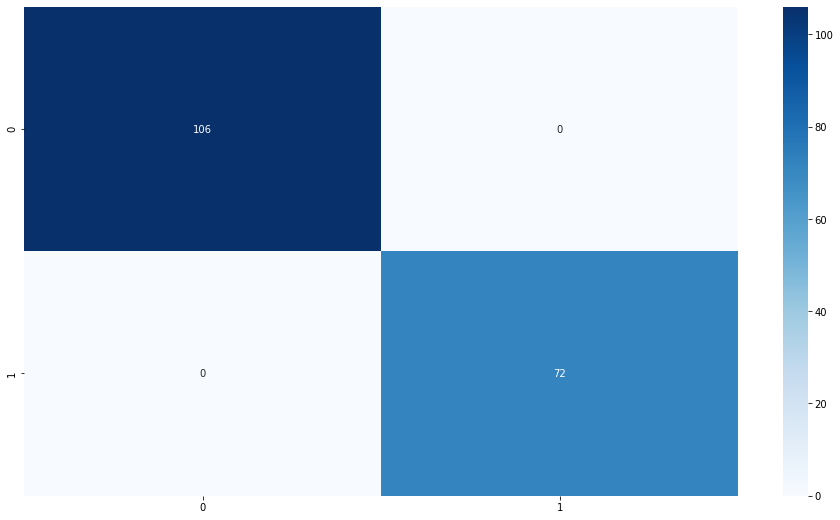

In [24]:
fig = plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='g',cmap=plt.cm.Blues)

In [25]:
import pickle

In [26]:
with open('models/LathesModel__input_train_{}__gra_{}__PCs_{}__{}.pkl'.format(input_id, 
                                                                  model.granularity_,
                                                                  model.N_PCs_,
                                                                  'NeuralNet'), 'wb') as f:
    pickle.dump(model,f)

### Change hyperparams

In [27]:
model2 = model.copy()

model2.change_hyperparams({'granularity':2})

model2.fit_after_tsfresh(X_train,y_train)

AttributeError: 'LathesModel' object has no attribute 'n_sensors'

In [ ]:
%%time
y_pred = model2.predict(X_test)

In [ ]:
model2.plot_soda()

In [ ]:
%%time
y_pred = model2.predict(X_test)

In [ ]:
Accuracy = accuracy_score(y_test,y_pred)*100
Precision = precision_score(y_test, y_pred, zero_division=0)*100
Recall = recall_score(y_test, y_pred, zero_division=0)*100
F1 = f1_score(y_test, y_pred, zero_division=0)*100


print("Accuracy:  {:5.2f}%".format(Accuracy))
print("Precision: {:5.2f}%".format(Precision))
print("Recall:    {:5.2f}%".format(Recall))
print("F1:        {:5.2f}%".format(F1))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
fig = plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='g',cmap=plt.cm.Blues)
plt.show()

In [ ]:
with open('models/LathesModel__input_train_{}__gra_{}__PCs_{}__{}.pkl'.format(input_id, 
                                                                  model.granularity_,
                                                                  model.N_PCs_,
                                                                  'NeuralNet'), 'wb') as f:
    pickle.dump(model2,f)